In [2]:
import os
import json
import pandas as pd

In [5]:
# Funkcia na rekurzívne prehľadávanie priečinkov a načítavanie JSON súborov
def load_annotations_from_directory(base_dir):
    annotations = []
    videos = 0
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.mkv'):
                videos += 1
                #file_path = os.path.join(root, file)
                #with open(file_path, 'r') as f:
                #    data = json.load(f)
                #    annotations.append(data)
    return videos

load_annotations_from_directory('/workspace/goal_spotting/.scratch/SoccerNet')

784

In [4]:
# Cesta k hlavnej zložke SoccerNet datasetu
base_dir = '/workspace/goal_spotting/.scratch/dataset224'
all_annotations = load_annotations_from_directory(base_dir)

print(f"Počet načítaných anotácií: {len(all_annotations)}")

Počet načítaných anotácií: 500


In [5]:
# Funkcia na extrahovanie udalostí z anotácií a ich uloženie do DataFrame
def annotations_to_dataframe(annotations):
    data = []
    match_id = 0
    for match in annotations:
        for event in match.get('annotations', []):
            event_data = {
                'match_id': match_id,
                'game_time': event.get('gameTime'),
                'event_type': event.get('label'),
                'position': event.get('position'),
                'team': event.get('team'),
                'visibility': event.get('visibility')
            }
            data.append(event_data)
        match_id += 1
    
    # Konvertujeme zoznam udalostí na DataFrame
    df = pd.DataFrame(data)
    return df

In [6]:
# Predpokladáme, že máš načítané anotácie
df_annotations = annotations_to_dataframe(all_annotations)

# Ukáž prvé riadky z DataFrame
print(df_annotations.head())

   match_id  game_time        event_type position            team visibility
0         0  1 - 00:00          Kick-off      136            away    visible
1         0  1 - 00:07  Ball out of play     7090  not applicable    visible
2         0  1 - 00:21          Throw-in    21479            away    visible
3         0  1 - 00:33  Ball out of play    33964  not applicable    visible
4         0  1 - 00:51          Throw-in    51397            away    visible


In [7]:
print(df_annotations.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110458 entries, 0 to 110457
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   match_id    110458 non-null  int64 
 1   game_time   110458 non-null  object
 2   event_type  110458 non-null  object
 3   position    110458 non-null  object
 4   team        110458 non-null  object
 5   visibility  110458 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.1+ MB
None


In [8]:
print(df_annotations.describe())

            match_id
count  110458.000000
mean      247.879674
std       143.564108
min         0.000000
25%       125.000000
50%       249.000000
75%       369.000000
max       499.000000


In [9]:
event_counts = df_annotations['event_type'].value_counts()
print(event_counts)

Ball out of play      31810
Throw-in              18918
Foul                  11674
Indirect free-kick    10521
Clearance              7896
Shots on target        5820
Shots off target       5256
Corner                 4836
Substitution           2839
Kick-off               2566
Direct free-kick       2200
Offside                2098
Yellow card            2047
Goal                   1703
Penalty                 173
Red card                 55
Yellow->red card         46
Name: event_type, dtype: int64


In [10]:
# Počet udalostí na zápas
events_per_match = df_annotations.groupby('match_id').size()
print(events_per_match.mean())

220.916


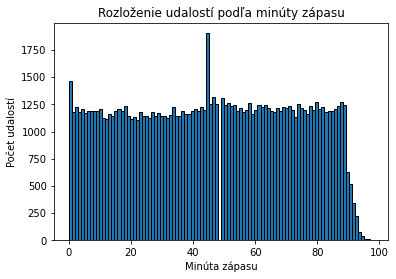

In [11]:
# Extrahovanie minút z 'game_time' (predpokladá, že 'game_time' má formát "polčas - MM:SS")
df_annotations['minute'] = df_annotations['game_time'].apply(lambda x: int(x.split(' - ')[1].split(':')[0]) + (45 if x.split(' - ')[0] == '2' else 0))

# Histogram rozloženia udalostí podľa minúty
import matplotlib.pyplot as plt

plt.hist(df_annotations['minute'], bins=100, edgecolor='black')
plt.xlabel('Minúta zápasu')
plt.ylabel('Počet udalostí')
plt.title('Rozloženie udalostí podľa minúty zápasu')
plt.show()

visible      90781
not shown    19677
Name: visibility, dtype: int64


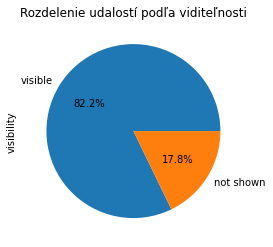

In [12]:
# Počet udalostí podľa viditeľnosti
visibility_counts = df_annotations['visibility'].value_counts()
print(visibility_counts)

# Vizualizácia ako pie chart
visibility_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Rozdelenie udalostí podľa viditeľnosti')
plt.show()

In [13]:
# Počet gólov na zápas
goals = df_annotations[df_annotations['event_type'] == 'Goal']
goals_per_match = goals.groupby('match_id').size()
print(goals_per_match.mean())

3.5928270042194095


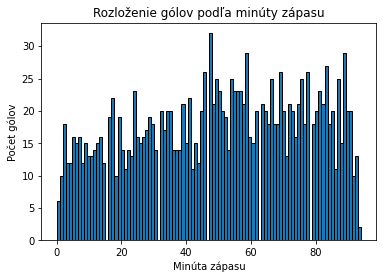

In [14]:
# Histogram rozloženia gólov podľa minúty
plt.hist(goals['minute'], bins=100, edgecolor='black')
plt.xlabel('Minúta zápasu')
plt.ylabel('Počet gólov')
plt.title('Rozloženie gólov podľa minúty zápasu')
plt.show()

In [15]:
# Spočítaj počet výskytov každej akcie
action_counts = df_annotations['event_type'].value_counts()
print(action_counts)

Ball out of play      31810
Throw-in              18918
Foul                  11674
Indirect free-kick    10521
Clearance              7896
Shots on target        5820
Shots off target       5256
Corner                 4836
Substitution           2839
Kick-off               2566
Direct free-kick       2200
Offside                2098
Yellow card            2047
Goal                   1703
Penalty                 173
Red card                 55
Yellow->red card         46
Name: event_type, dtype: int64


1. Goly: Goals
2. Velke sance: Clearance, , Penalty, Shots on target, Shots off target, Corner
3. Nie sance: Kick-off, Substitution, Ball out of play, Throw-in